# Discharge 1 Forecast all steps


First we are going to open a CSV File containing EFAS Stations.
We will select a random station.

In [1]:
import pandas as pd
from random import sample
stations = pd.read_csv('../static/EFAS_calib_stations_metadata.csv',encoding='iso-8859-1')
station = stations.sample(n=1)
station

,ObsID,StationName,Provider ID,Country code,StationLat,StationLon,Height,Height Units,DrainingArea.km2.Provider,Catchment Area Units,...,DiffDays_hist_6,DiffDays_nrt_6,cal_hist_24h,cal_nrt_24h,cal_hist_6h,cal_nrt_6h,CAL_TYPE,Notes,EC_calib,Dam/Lake
164,308,Kistefoss,1002,NO,60.221812,10.361305,120,m.a.s.l.,3704.53,km2,...,-,3854,TRUE,TRUE,FALSE,TRUE,NRT_6h,lake strongly regulated,3,L


We will open a dataset containing the ECMWF Ensemble Forecast (50 members) containg River Dicharge over 24 hours from Step 0 to 360 from the forecast 15th November 2018 00Z

In [2]:
import xarray as xr
ds = xr.open_dataset('../data/eue_15111800.nc')

We can quickly see the variable's of the file using ds.data_vars

In [3]:
ds.data_vars

Data variables:
    dis24                         (number, step, y, x) float32 ...
    lambert_azimuthal_equal_area  int32 ...
    land_binary_mask              (y, x) int8 ...
    upArea                        (y, x) float32 ...

We can check the data_variables dimensions using dis.dims

Number being the number of the Model

In [4]:
ds.dims

Frozen(SortedKeysDict({'y': 950, 'x': 1000, 'number': 50, 'step': 15}))

Now we know the variable and the dimensions we can look at the shape of the variable.

In [5]:
ds.dis24.shape

(50, 15, 950, 1000)

Now we will open the Historical Simulations

In [6]:
clim = xr.open_dataset('../data/clim_151118.nc')
clim


<xarray.Dataset>
Dimensions:                       (time: 15, x: 1000, y: 950)
Coordinates:
  * y                             (y) float64 5.498e+06 5.492e+06 ... 7.525e+05
  * x                             (x) float64 2.502e+06 2.508e+06 ... 7.498e+06
  * time                          (time) datetime64[ns] 2018-11-15T06:00:00 ... 2018-11-29T06:00:00
    step                          timedelta64[ns] ...
    surface                       int64 ...
    latitude                      (y, x) float32 ...
    longitude                     (y, x) float32 ...
    valid_time                    (time) datetime64[ns] ...
Data variables:
    dis24                         (time, y, x) float32 ...
    lambert_azimuthal_equal_area  int32 ...
    land_binary_mask              (y, x) int8 ...
    upArea                        (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    G

Now we will plot a time series of the derived station by using its Lat and Lon, locating the nearest point

In [7]:
import pyproj
inputEPSG = pyproj.Proj(init='epsg:4326')   # ref system EFAS-IS
outputEPSG = pyproj.Proj(init='epsg:3035')  # ref system LISFLOOD

x_lsf, y_lsf = pyproj.transform(inputEPSG, outputEPSG, float(station.StationLon.values), float(station.StationLat.values))

# extract data for selected point in netcdf file by LISFLOOD coordinates
dsloc = ds.sel(x=x_lsf,y=y_lsf,method='nearest')
climloc = clim.sel(x=x_lsf,y=y_lsf,method='nearest')

Now that we have a location in the dsloc and climloc variables we can plot the data.
Below we will first align the data so that the time fields are in the same format and reference

Historical Simulations are based on the 06UTC of the Date in the Time field
Forecast fields are based on the timestep from the basetime.

In [8]:
import numpy as np

base=dsloc.time.values
time=np.array([base+np.timedelta64(step) for step in dsloc.step.values])

We will now construct a dataframe consisting of a few Ensemble Members

Here we have placed all Ensemble members into a dataframe

In [9]:
df=pd.DataFrame({
    'TimeStep': time, # Time data from the Ensemble Data file as Times (Base + Delta("STEP"))
    'Historical_times':np.array(climloc.time.values+np.timedelta64(climloc.step.values)), # Historical Times from the Climatology File
    'Historical': climloc.dis24.values}) # Historical Data from the Climatology file

for number in dsloc.number.values:
    df['Ensemble_Member_'+str(number)] = dsloc.dis24[number-1,:]
    
df

,TimeStep,Historical_times,Historical,Ensemble_Member_1,Ensemble_Member_2,Ensemble_Member_3,Ensemble_Member_4,Ensemble_Member_5,Ensemble_Member_6,Ensemble_Member_7,...,Ensemble_Member_41,Ensemble_Member_42,Ensemble_Member_43,Ensemble_Member_44,Ensemble_Member_45,Ensemble_Member_46,Ensemble_Member_47,Ensemble_Member_48,Ensemble_Member_49,Ensemble_Member_50
0,2018-11-16,2018-11-16 06:00:00,46.098389,45.661865,45.618408,45.650146,45.612793,45.731689,45.625732,45.662598,...,45.623047,45.637695,45.624268,45.641846,45.674805,45.628174,45.618408,45.649414,45.682861,45.656006
1,2018-11-17,2018-11-17 06:00:00,46.992920,46.817383,46.817139,46.832520,46.776367,46.864990,46.788818,46.836914,...,46.771240,46.811279,46.816406,46.823242,46.866943,46.793213,46.780029,46.820801,46.815674,46.846924
2,2018-11-18,2018-11-18 06:00:00,47.151367,47.123291,47.105957,47.164795,47.091797,47.180664,47.102295,47.158203,...,47.083984,47.137207,47.144043,47.127930,47.190430,47.100342,47.089355,47.153809,47.108887,47.178711
3,2018-11-19,2018-11-19 06:00:00,46.817871,46.850830,46.844482,46.911377,46.853271,46.912109,46.846191,46.909180,...,46.827637,46.880127,46.871582,46.854248,46.915527,46.833740,46.836426,46.896484,46.846191,46.910156
4,2018-11-20,2018-11-20 06:00:00,46.154785,46.183838,46.167480,46.242188,46.168457,46.248535,46.162842,46.208008,...,46.156738,46.198242,46.189453,46.133789,46.235840,46.166992,46.173584,46.222656,46.161621,46.199463
5,2018-11-21,2018-11-21 06:00:00,45.268311,45.259033,45.254395,45.300049,45.209229,45.290283,45.227539,45.232666,...,45.180664,45.248535,45.253174,45.154785,45.296143,45.205811,45.246094,45.278809,45.199463,45.205322
6,2018-11-22,2018-11-22 06:00:00,44.229248,44.154541,44.183594,44.187744,44.093994,44.182373,44.121094,44.103027,...,44.028320,44.152100,44.141357,44.049316,44.160156,44.076904,44.083740,44.179443,44.072754,44.079102
7,2018-11-23,2018-11-23 06:00:00,43.115479,42.981689,43.038086,43.027100,42.920166,42.986084,42.943115,42.909668,...,42.818115,42.963867,42.967285,42.878662,42.973633,42.886963,42.847412,43.014648,42.881592,42.895752
8,2018-11-24,2018-11-24 06:00:00,41.981445,41.796631,41.855957,41.854004,41.736816,41.784912,41.743164,41.710938,...,41.612549,41.735596,41.775635,41.639893,41.779297,41.714600,41.608398,41.819336,41.682129,41.713379
9,2018-11-25,2018-11-25 06:00:00,40.869873,40.623291,40.642334,40.640625,40.553955,40.609131,40.549316,40.528809,...,40.416016,40.468506,40.583496,40.420410,40.572021,40.609131,40.373047,40.633301,40.504883,40.556641


Now we will plot the members of the Dataframe

In [10]:
stations


,ObsID,StationName,Provider ID,Country code,StationLat,StationLon,Height,Height Units,DrainingArea.km2.Provider,Catchment Area Units,...,DiffDays_hist_6,DiffDays_nrt_6,cal_hist_24h,cal_nrt_24h,cal_hist_6h,cal_nrt_6h,CAL_TYPE,Notes,EC_calib,Dam/Lake
0,2,Hofkirchen,1004,DE,48.676627,13.115212,299.6,m,47496,km2,...,-,1763,TRUE,TRUE,FALSE,TRUE,NRT_6h,-,3,-
1,4,Barby,1004,DE,51.984836,11.882244,46.11,m,94060,km2,...,549,2211,TRUE,TRUE,FALSE,TRUE,NRT_6h,-,3,-
2,5,Wittenberg / Lutherstadt,1004,DE,51.856531,12.646309,62.44,m,61879,km2,...,-,2206,TRUE,TRUE,FALSE,TRUE,NRT_6h,-,3,-
3,9,Rathenow UP,1004,DE,52.607446,12.321014,24.52,m,19288.46,km2,...,-,-,TRUE,FALSE,FALSE,FALSE,HIST_24h,-,3,-
4,11,Calbe Grizehne,1004,DE,51.916414,11.812211,49.36,m,23719,km2,...,549,2206,TRUE,TRUE,FALSE,TRUE,NRT_6h,-,3,-
5,12,Tangermuende,1004,DE,52.541308,11.978054,27.56,m,97780,km2,...,-,2194,TRUE,TRUE,FALSE,TRUE,NRT_6h,-,3,-
6,14,Wittenberge,1004,DE,52.985531,11.759441,16.72,m,123532,km2,...,-,2206,TRUE,TRUE,FALSE,TRUE,NRT_6h,-,3,-
7,15,Aken,1004,DE,51.857869,12.058857,50.2,m,70093,km2,...,549,2211,TRUE,TRUE,FALSE,TRUE,NRT_6h,-,3,-
8,18,Halle-Trotha UP,1004,DE,51.514254,11.954551,69.34,m,17988,km2,...,549,2206,TRUE,TRUE,FALSE,TRUE,NRT_6h,small outliers,3,-
9,19,Neu Darchau,1004,DE,53.232262,10.888800,5.68,m,131950,km2,...,-,2211,TRUE,TRUE,FALSE,TRUE,NRT_6h,-,3,-


<IPython.core.display.Javascript object>


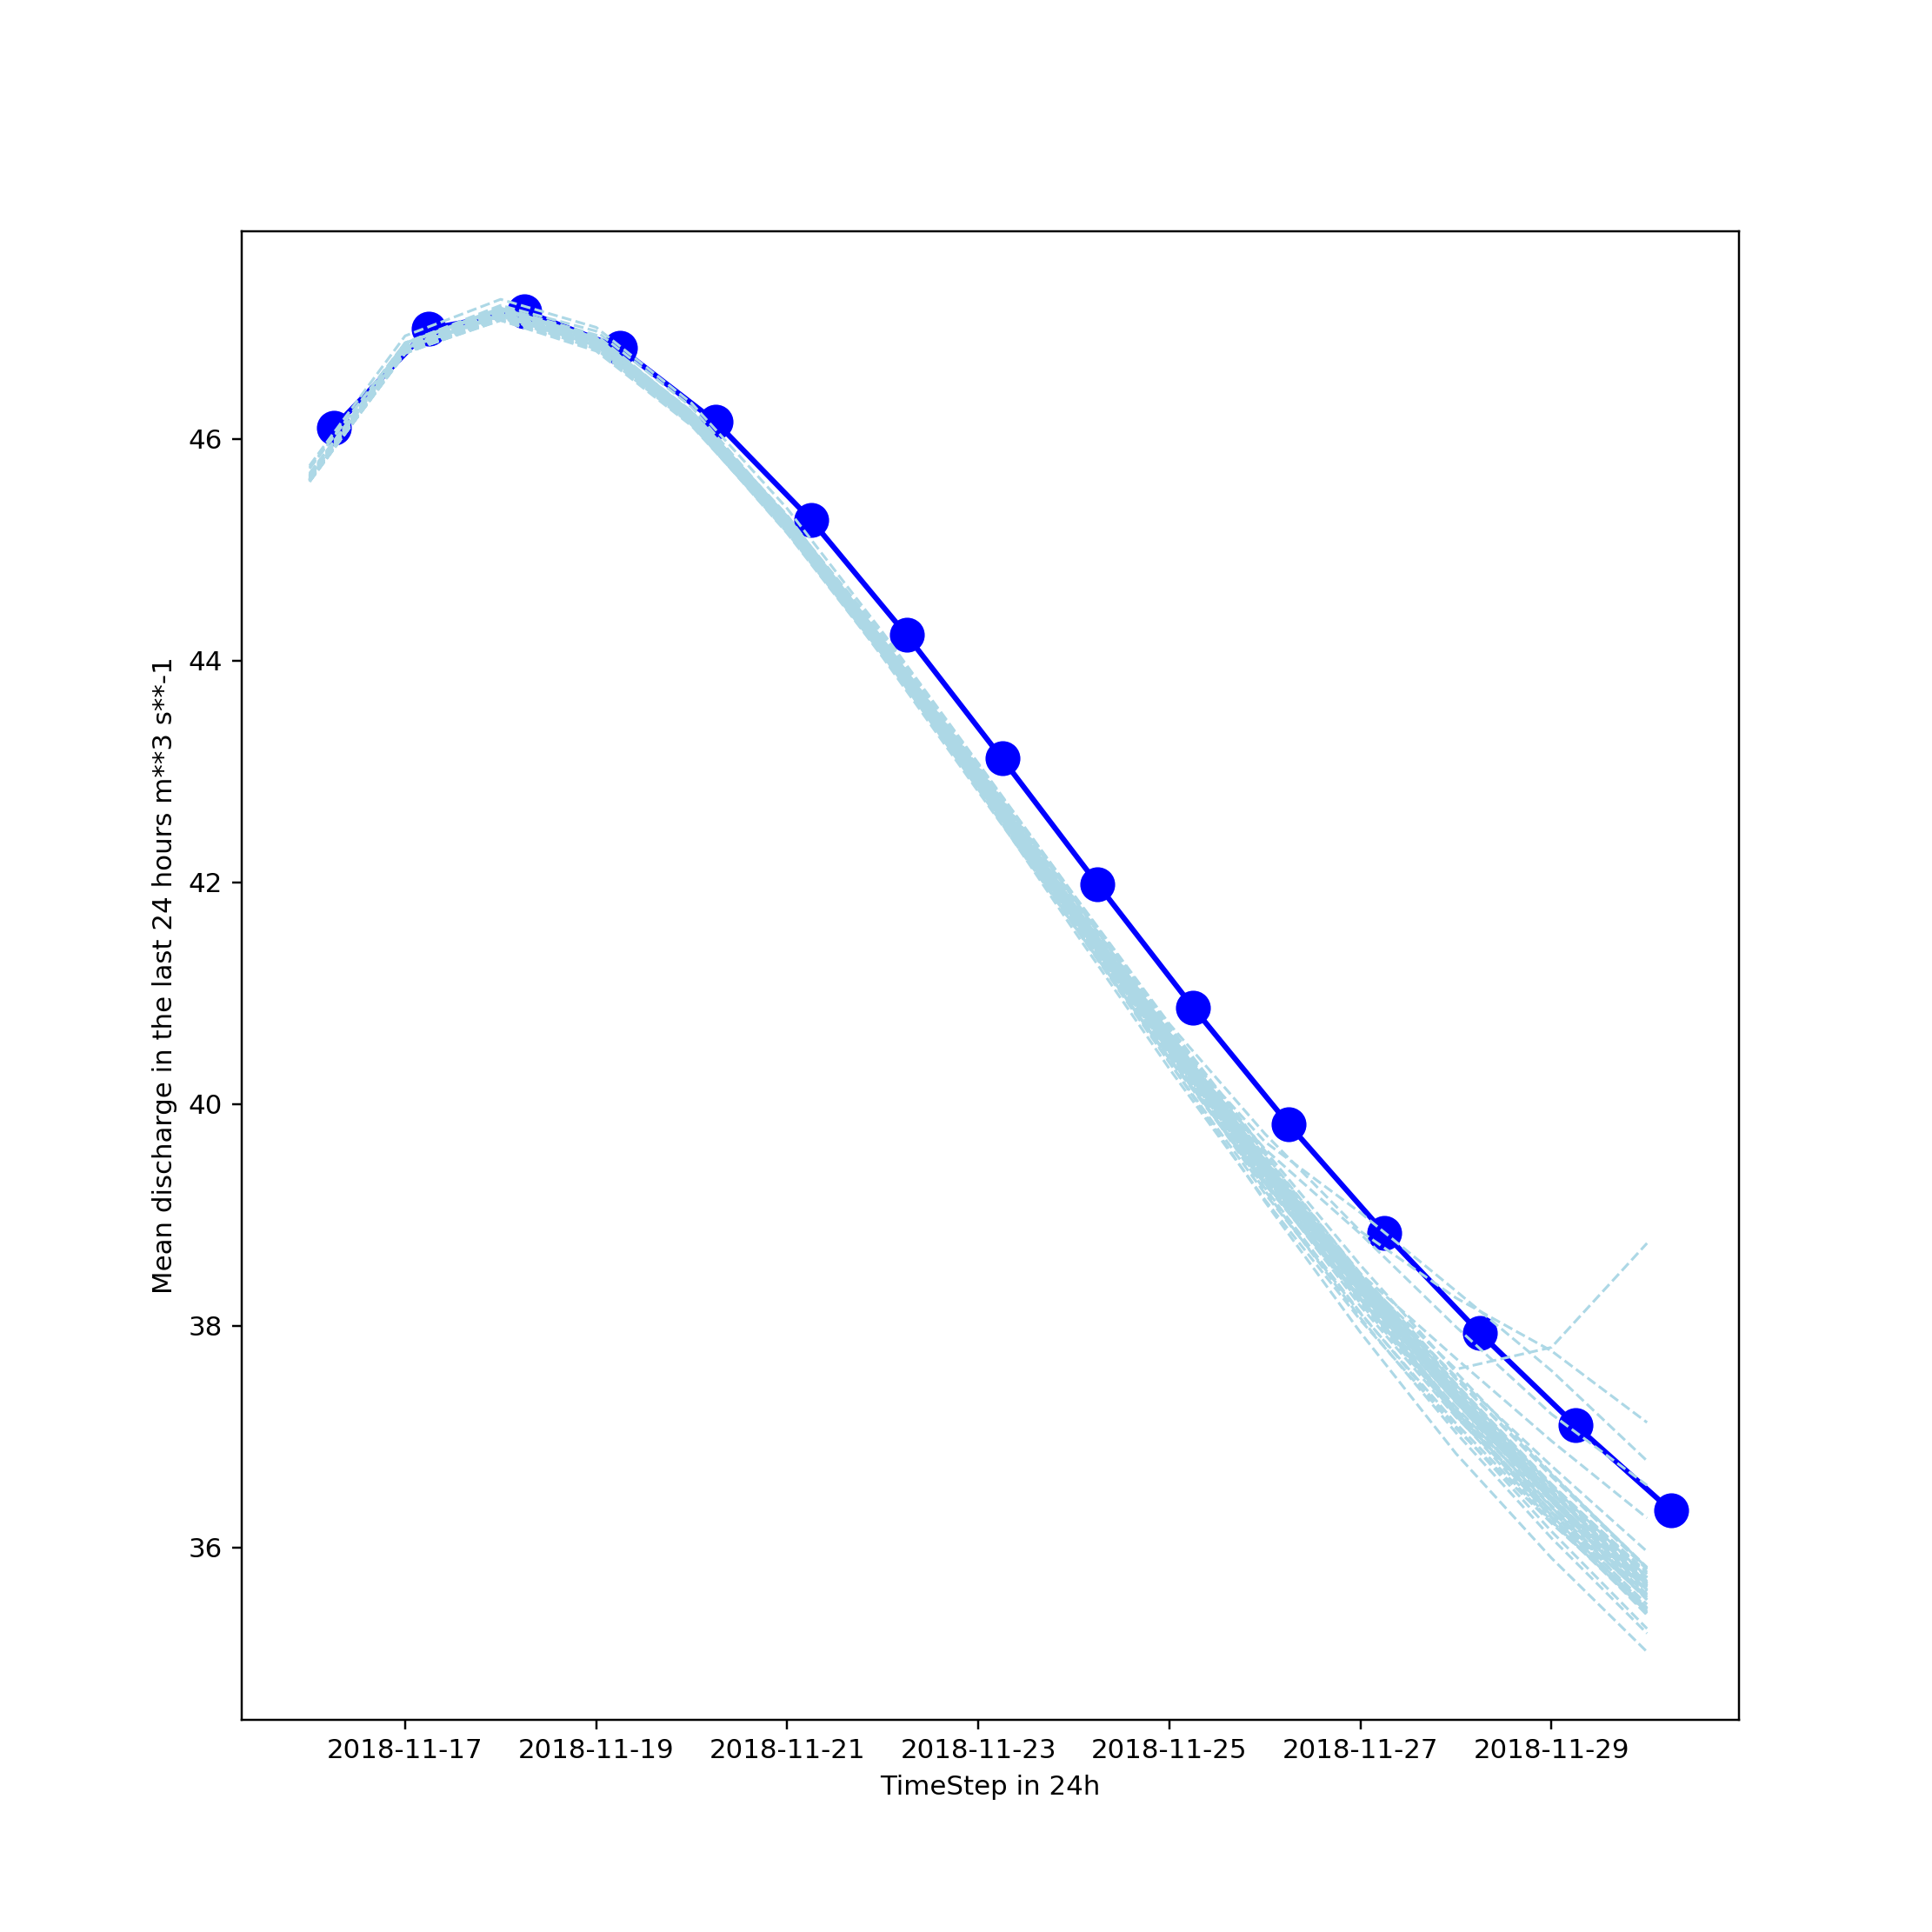

In [13]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plot

matplotlib.rcParams['figure.figsize'] = [12, 12]

plot.figure(figsize=(10,10),num='EFAS ECMWF 50 Perturbed Members vs Historical Simulations')

plot.xlabel('TimeStep in 24h')
plot.ylabel(dsloc.dis24.GRIB_name+' ' + dsloc.dis24.GRIB_units)
plot.plot( 'Historical_times', 'Historical', data=df, marker='o', markerfacecolor='blue', markersize=12, color='blue', linewidth=2)
for ens_member in df.filter(regex='Ensemble'):
    plot.plot( 'TimeStep', ens_member, data=df, marker='', color='lightblue', linewidth=1, linestyle='dashed')
plot.show()

We can also look at the member distribution using a box plot
This allows us to look at the spread of the ensemble values.
And adding the Historical Simulations of Discharge on top as a Line Plot to see how they compare.

<IPython.core.display.Javascript object>


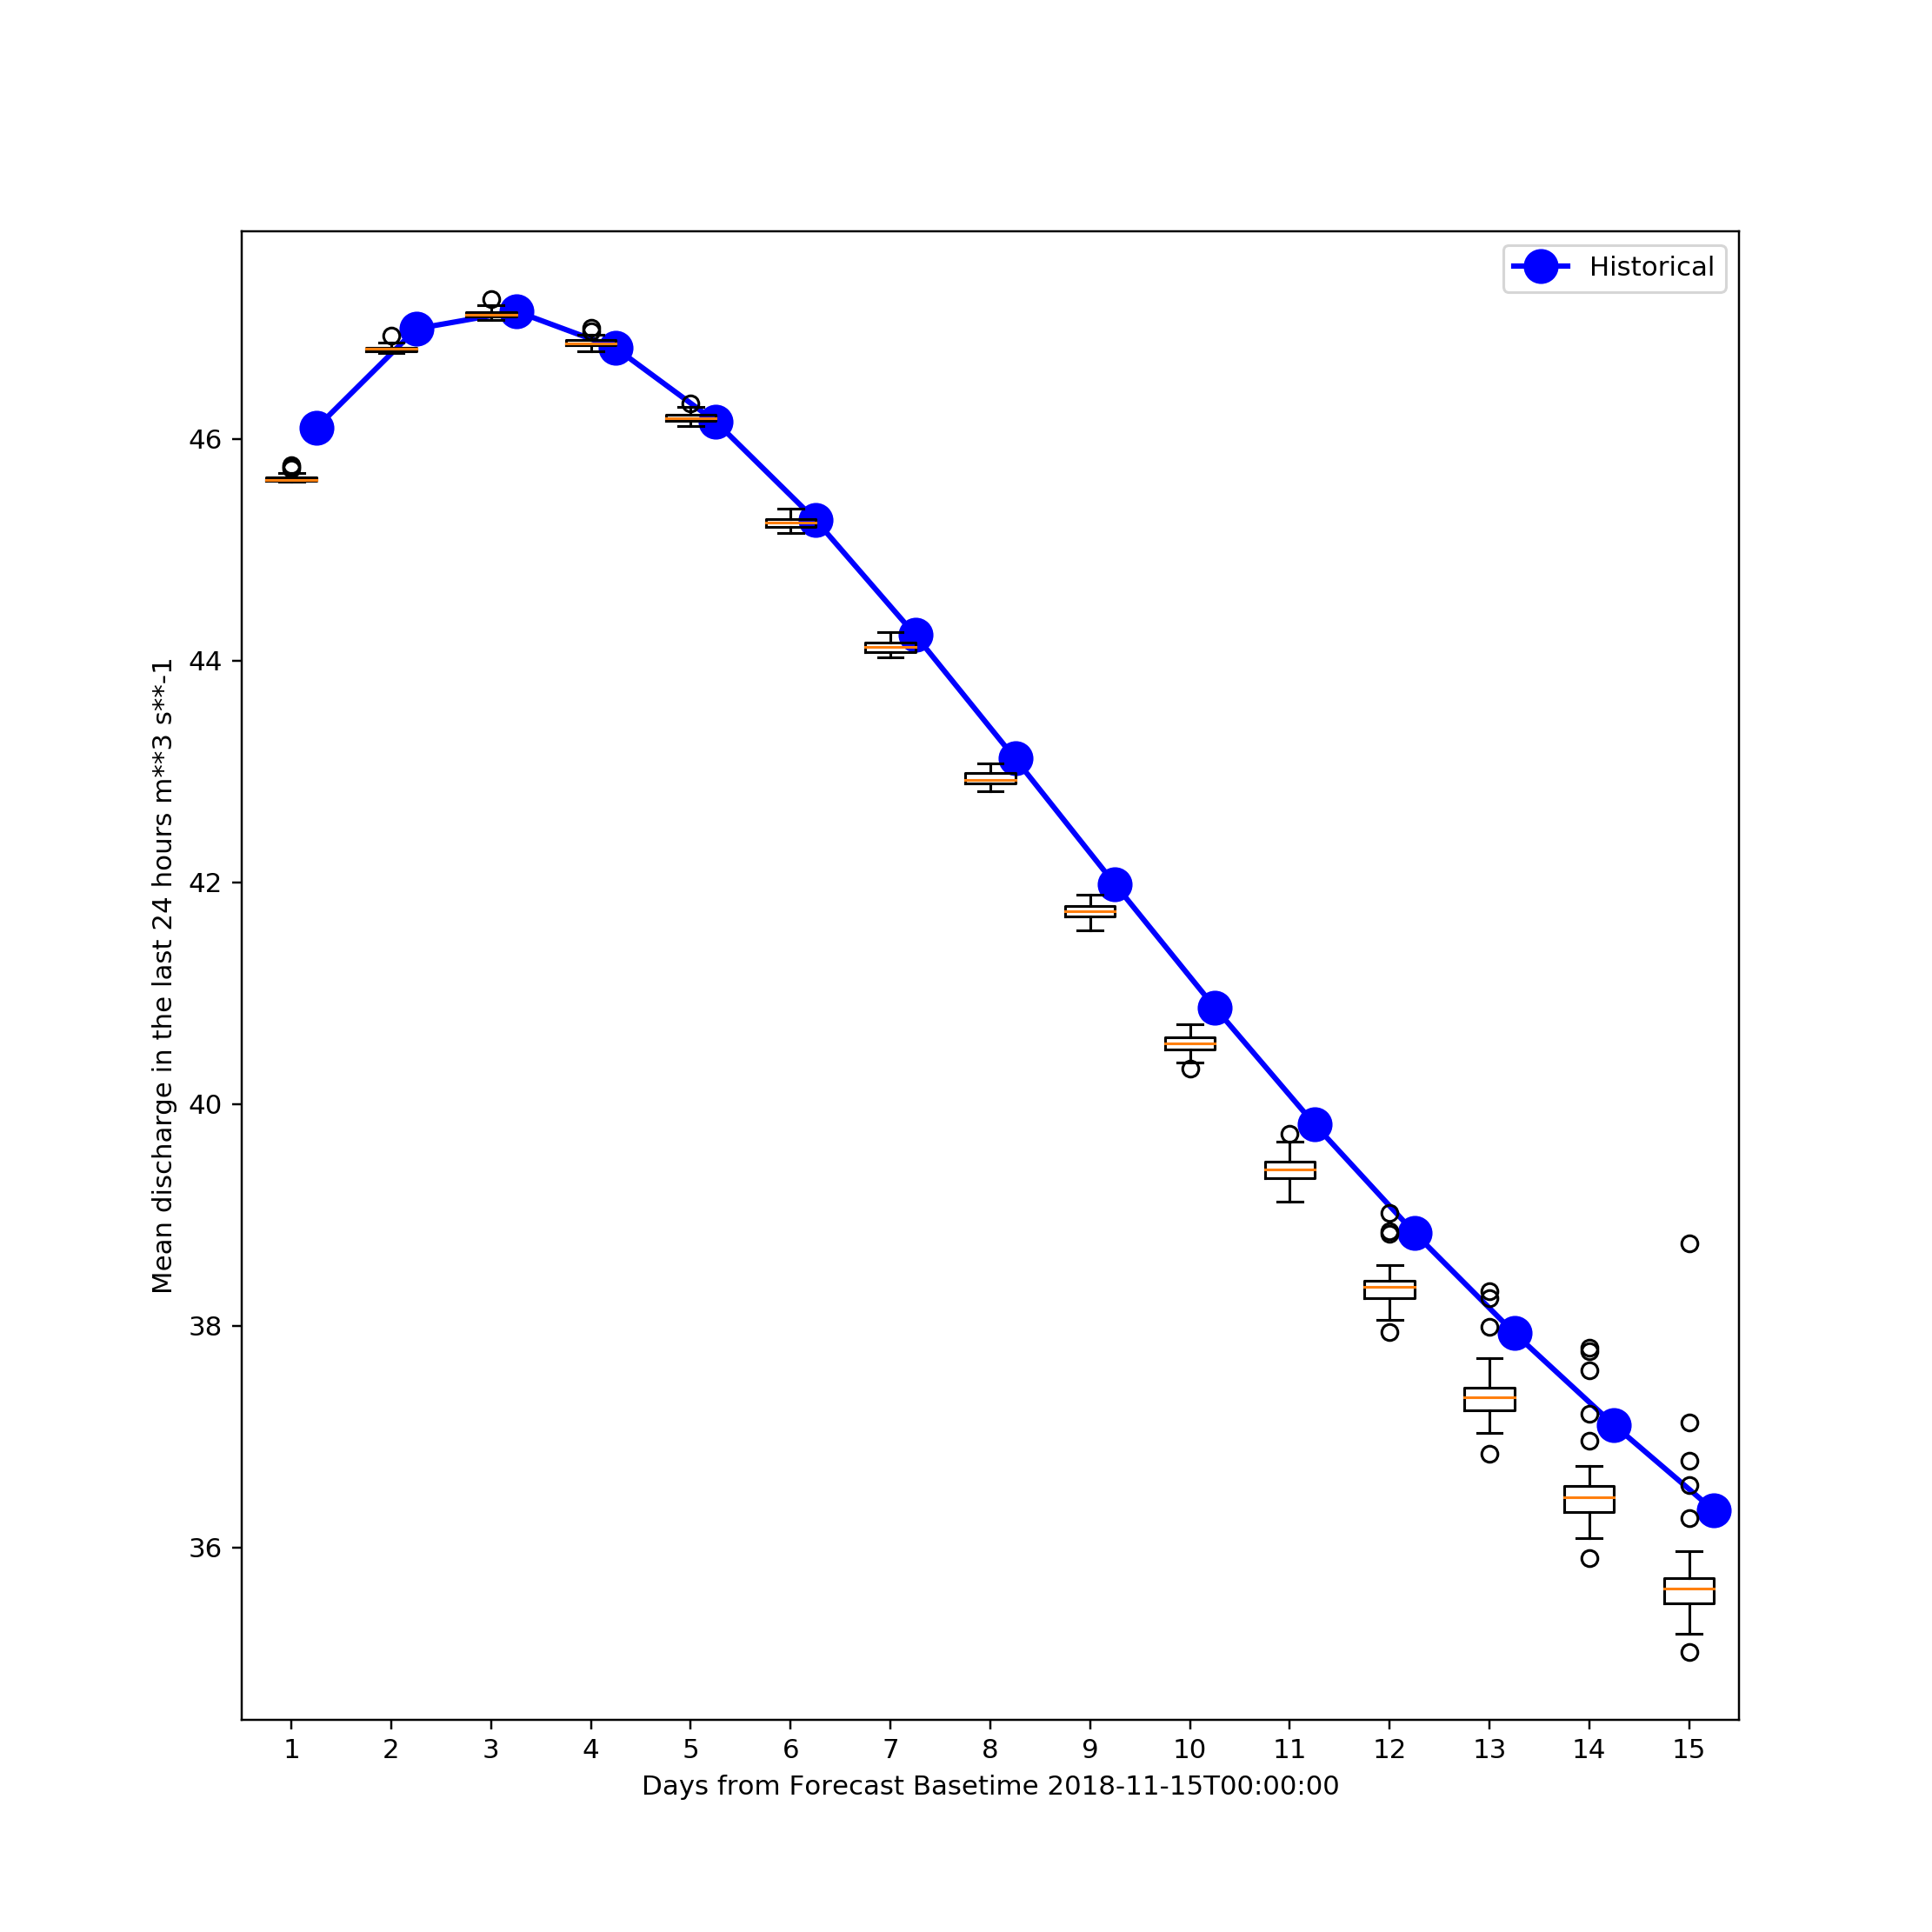

In [14]:
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = [12, 12]

plot.figure(figsize=(10,10),num='EFAS ECMWF 50 Perturbed Members vs Historical Simulations Box Plot')
df2=df.filter(like='Ensemble')

plot.ylabel(dsloc.dis24.GRIB_name+' ' + dsloc.dis24.GRIB_units)
plot.xlabel('Days from Forecast Basetime ' + np.datetime_as_string(ds.time.values,unit='s'))
# Here we add the 6 Hour Base time and 24h to the values just to align it for the box plot.
plot.plot(df2.index+1.25,'Historical', data=df, marker='o', markerfacecolor='blue', markersize=12, color='blue', linewidth=2) 
plot.boxplot(df2)
plot.legend()
plot.show()